In [37]:
import warnings
warnings.filterwarnings('ignore')


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # FIX: correct import syntax
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

# Define the path to the Excel file
file_path = '/Users/feliciaangel/Documents/portfolio/churn/Prediction_Data.xlsx'

# Define the sheet name to read data from
sheet_name = 'vw_ChurnData'

# Read the data from the specified sheet into a pandas DataFrame
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the fetched data
print(data.head())


  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   11098-MAD  Female   30     Yes  Madhya Pradesh                    0   
1   11114-PUN    Male   51      No          Punjab                    5   
2   11167-WES  Female   43     Yes     West Bengal                    3   
3   11179-MAH    Male   35      No     Maharashtra                   10   
4   11180-TAM    Male   75     Yes      Tamil Nadu                   12   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                31     Deal 1           Yes             No  ...   
1                 9     Deal 5           Yes             No  ...   
2                28     Deal 1           Yes            Yes  ...   
3                12        NaN           Yes             No  ...   
4                27     Deal 2           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal          95.10       6683.40             0   
1  Bank Wi

In [49]:
# Remove columns not needed for modeling
features = data.drop(columns=['Customer_ID', 'Churn_Category', 'Churn_Reason'])

# Define categorical columns to encode
categorical_cols = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

# Apply LabelEncoder for each categorical column
label_encoders = {}
for col in categorical_cols:
    encoder = LabelEncoder()
    features[col] = encoder.fit_transform(features[col])
    label_encoders[col] = encoder  # Save encoders if needed later

# Convert target variable to numeric: 1 if 'Churned', 0 if 'Stayed'
features['Customer_Status'] = features['Customer_Status'].replace({'Stayed': 0, 'Churned': 1})

# Define predictors and target
X = features.drop(columns='Customer_Status')
y = features['Customer_Status']

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


=== Confusion Matrix ===
[[776  71]
 [132 223]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       847
           1       0.76      0.63      0.69       355

    accuracy                           0.83      1202
   macro avg       0.81      0.77      0.79      1202
weighted avg       0.83      0.83      0.83      1202



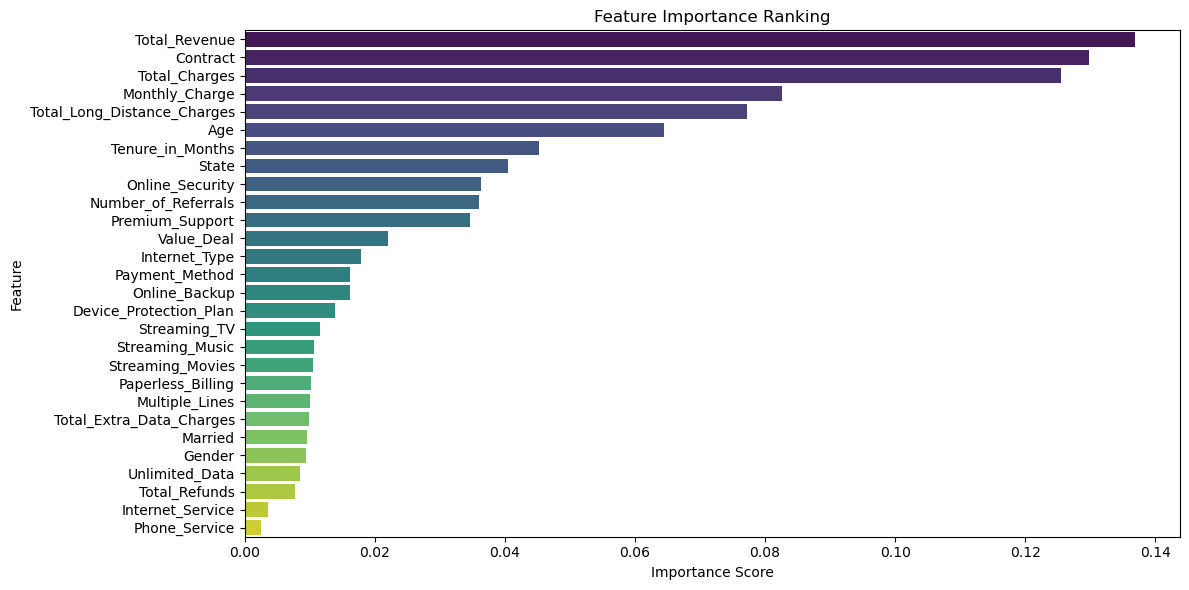

In [51]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions on test set
predictions = model.predict(X_test)

# Evaluate model performance
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))

print("\n=== Classification Report ===")
print(classification_report(y_test, predictions))

# Analyze feature importance
feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot ranked feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx], palette="viridis")
plt.title("Feature Importance Ranking")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [55]:
# Load joiner data from Excel
joiner_df = pd.read_excel(file_path, sheet_name='vw_JoinData')

# Preserve Customer_ID for reference
customer_ids = joiner_df['Customer_ID']

# Keep original dataframe for later merge
result_df = joiner_df.copy()

# Prepare features for prediction by dropping unnecessary columns
features_to_drop = ['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason']
X_new = joiner_df.drop(columns=features_to_drop)

# Apply label encoding using previously saved encoders
for col in X_new.select_dtypes(include='object'):
    X_new[col] = label_encoders[col].transform(X_new[col])

# Generate predictions
predicted_status = model.predict(X_new)

# Attach predictions to result dataframe
result_df['Customer_Status_Predicted'] = predicted_status

# Filter predicted churners only
churned_customers = result_df[result_df['Customer_Status_Predicted'] == 1]

# Export result as CSV
churned_customers.to_csv(r"C:\yourpath\Predictions.csv", index=False)

print("Predictions saved to Predictions.csv")


✅ Predictions saved to Predictions.csv
